## Anomaly Detection
I use an autoencoder neural network to identify vibrational anomalies from motor readings. The goal is to be able to predict future faults/failures by detecting anomalous readings before they happen. The data set contains current readings of a 3-phase AC motor (3.2hp) 
motor current signature analysis and model-based VI analysis to be done to detect anomalies 

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [3]:
# import libraries
import os
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import hilbert
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [4]:
# # set random seed
# # seed(10)
# # set_random_seed(10)
# tf.random.set_seed(10)

# Data loading and pre-processing
Read all Files and create a DataFrame,
and then merge together everything in a single dataframe.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Step 1: get a list of all csv files in target directory
my_dir = "/content/drive/MyDrive/Anomaly_detection_submission/s3Files-20230301T055117Z-001/s3Files"
filelist = []
filesList = []
os.chdir(my_dir)

In [7]:
# Step 2: Build up list of files:
for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filelist.append(fileName) #filename without extension
    filesList.append(files) #filename with extension

In [8]:
df={}
data_master=pd.DataFrame()
for i in range(2,319):
    x='data'+str(i)+'.txt'
    df[i]=pd.read_csv(x,sep=',',header=None)
    df[i].drop(columns=[0,4],inplace=True)
    data_master=data_master.append(df[i])

In [9]:
print("Dataset shape:", data_master.shape)
data_master.head()

Dataset shape: (3170000, 3)


1     2    3
0  2102  2318   97
1  2095  2326   94
2  2087  2336   78
3  1867  2429  283
4  1862  2430  297

In [10]:
merged_data = data_master

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the anomalous activity.

In [11]:
train = merged_data[:2536000]
test = merged_data[2536000:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (2536000, 3)
Test dataset shape: (634000, 3)


In [12]:
train.iloc[:,0]

0       2102
1       2095
2       2087
3       1867
4       1862
        ... 
5995    2156
5996    2163
5997    2167
5998    2178
5999    2178
Name: 1, Length: 2536000, dtype: int64

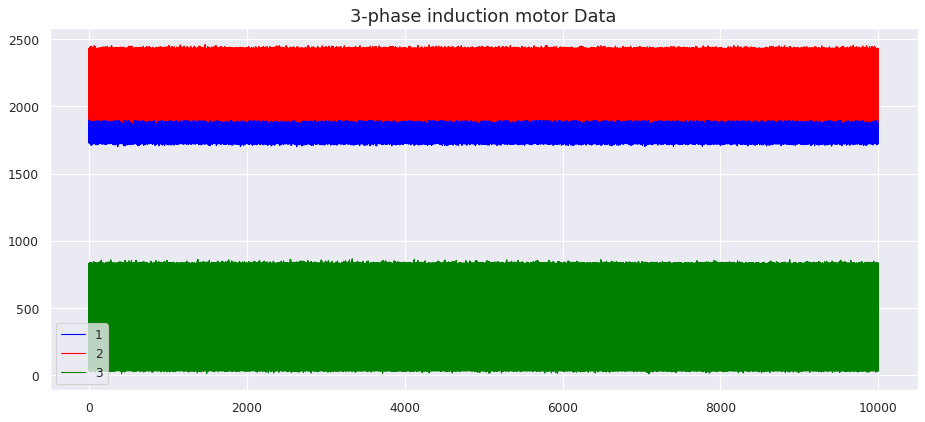

In [13]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train.iloc[:,0], label='1', color='blue', animated = True, linewidth=1)
ax.plot(train.iloc[:,1], label='2', color='red', animated = True, linewidth=1)
ax.plot(train.iloc[:,2], label='3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('3-phase induction motor Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [14]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

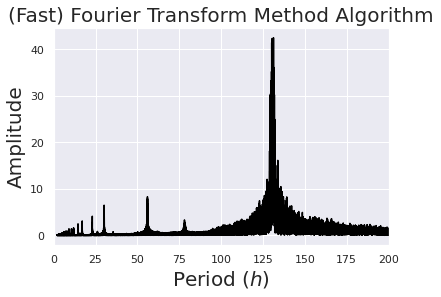

In [18]:
# Frequency Analysis
# the Fourier transform to do the frequency analysis of our signal. ploting the Fourier Spectrum:

data_fft = data_master
y = np.array(data_fft.iloc[:,0])
x = data_fft.index
y_detrend = signal.detrend(y)


FFT1 =np.fft.fft(y_detrend)
new_N=int(len(FFT1)/2) 
f_nat=1
new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
new_Xph=1.0/(new_X)
FFT_abs=np.abs(FFT1)
#plt.figure(figsize=(100,65))
plt.plot(new_Xph,2*FFT_abs[0:int(len(FFT1)/2.)]/len(new_Xph),color='black')
plt.xlabel('Period',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=20)
plt.grid(True)
plt.xlim(0,200)
plt.show()


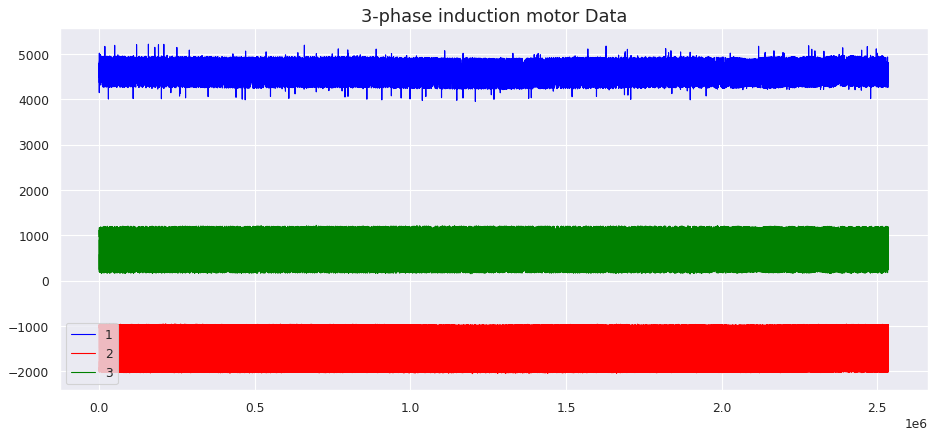

In [15]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('3-phase induction motor Data', fontsize=16)
plt.show()

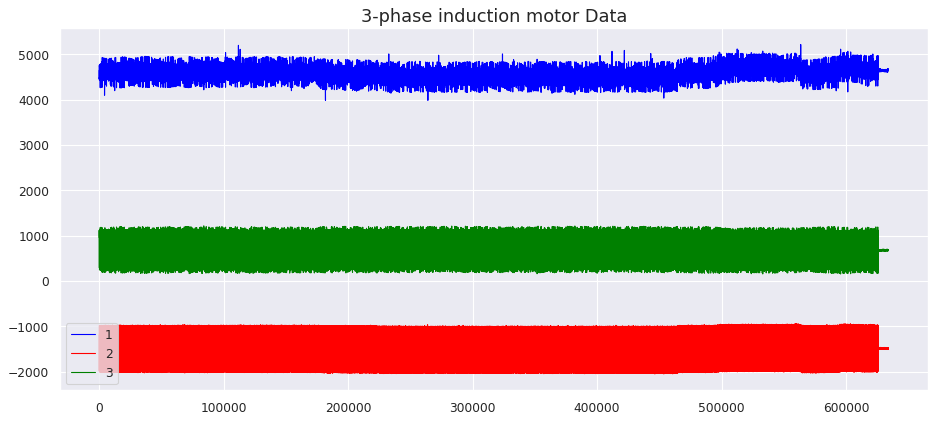

In [16]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('3-phase induction motor Data', fontsize=16)
plt.show()

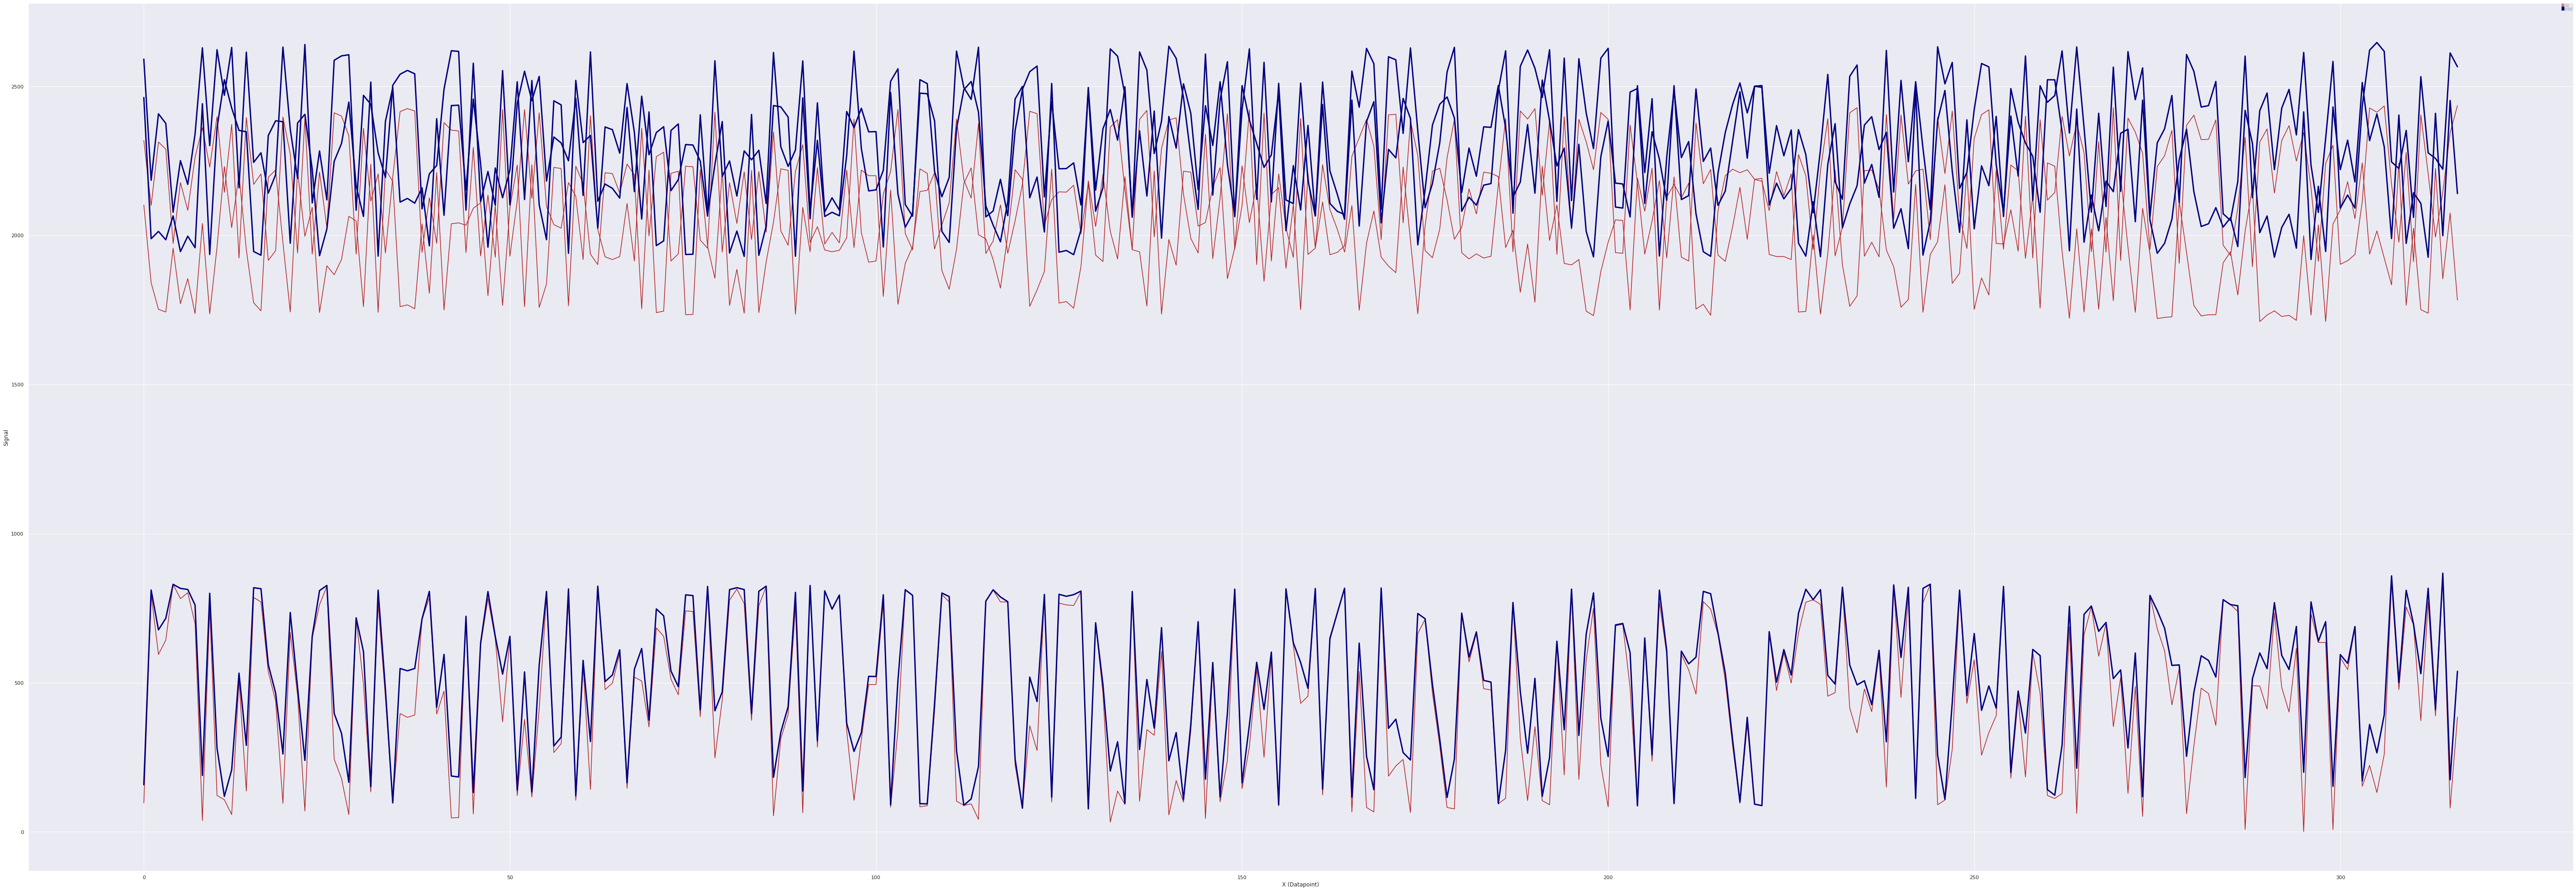

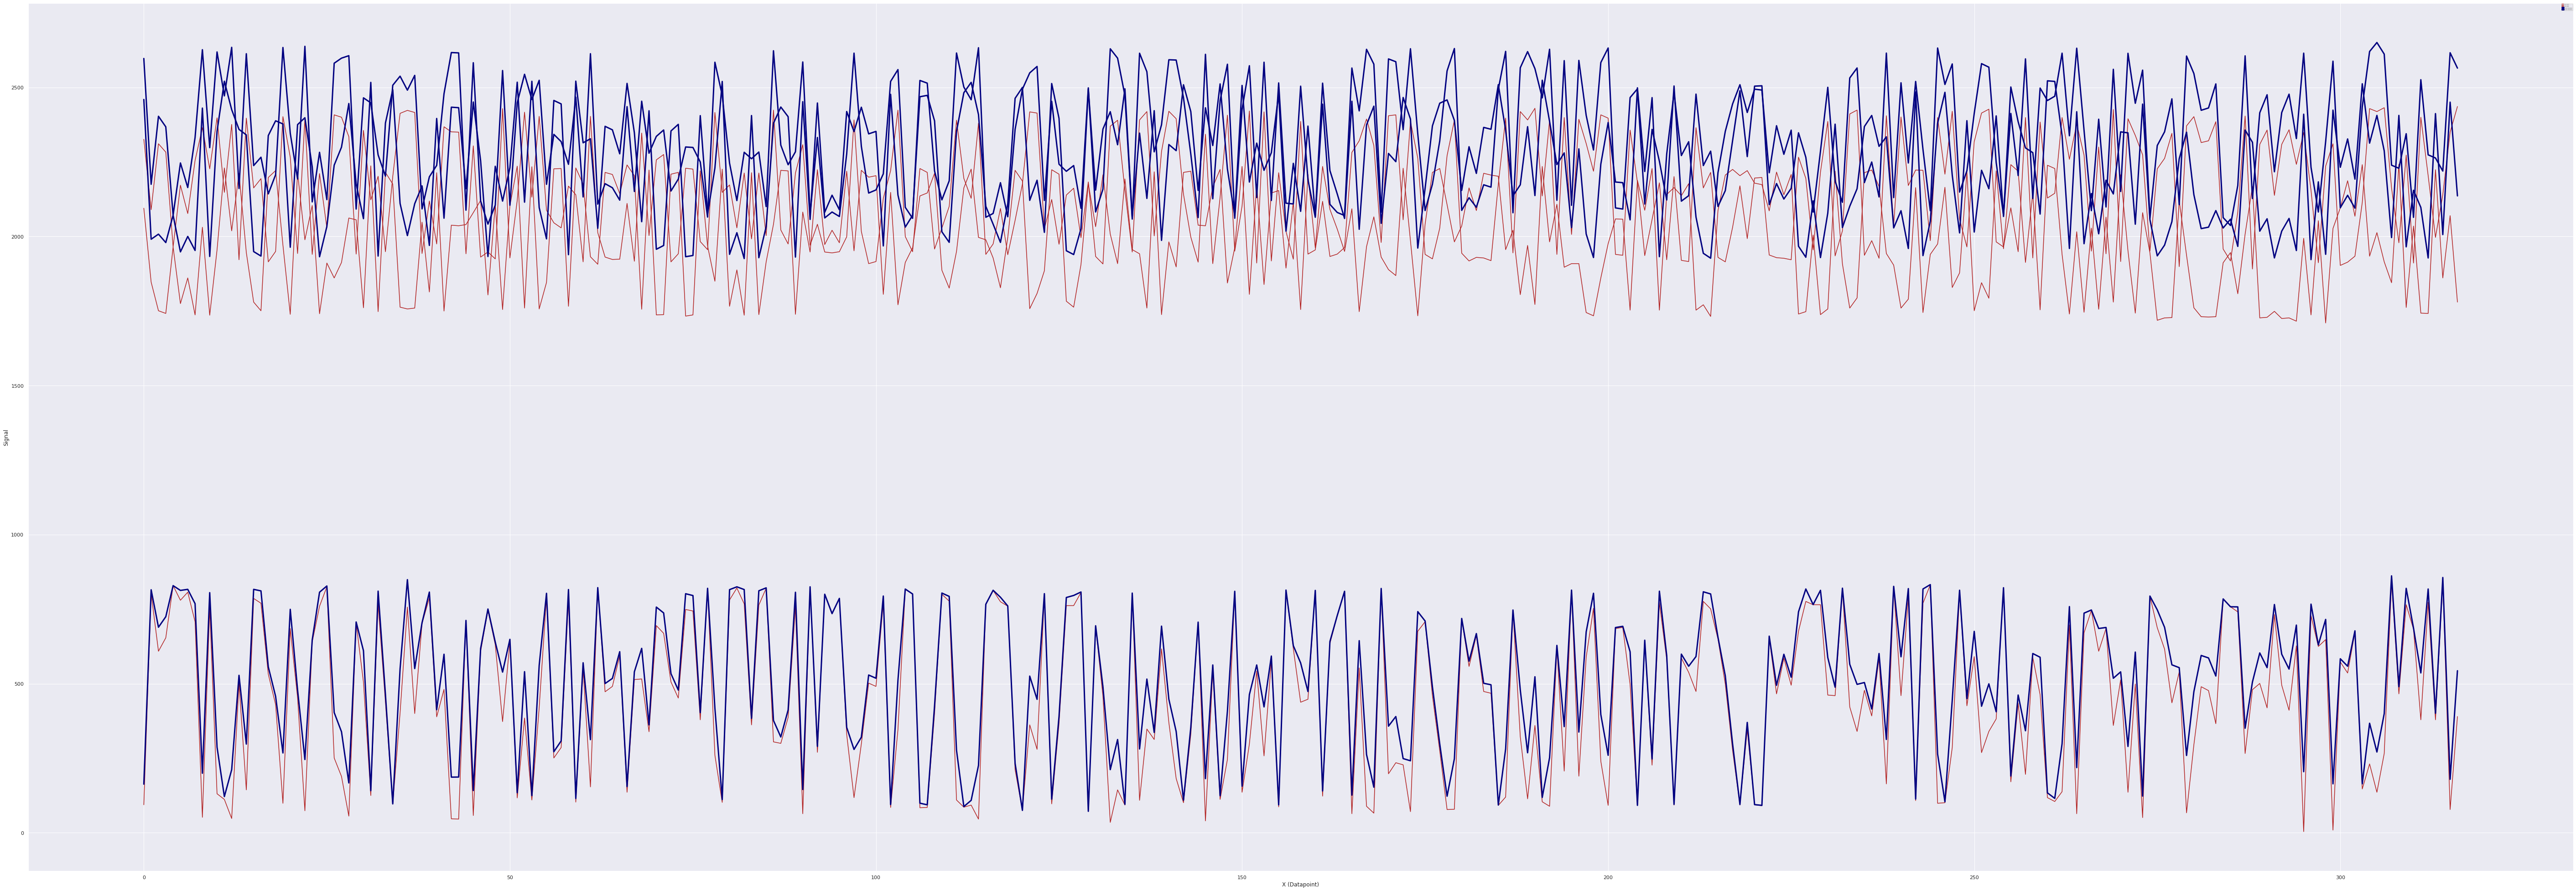

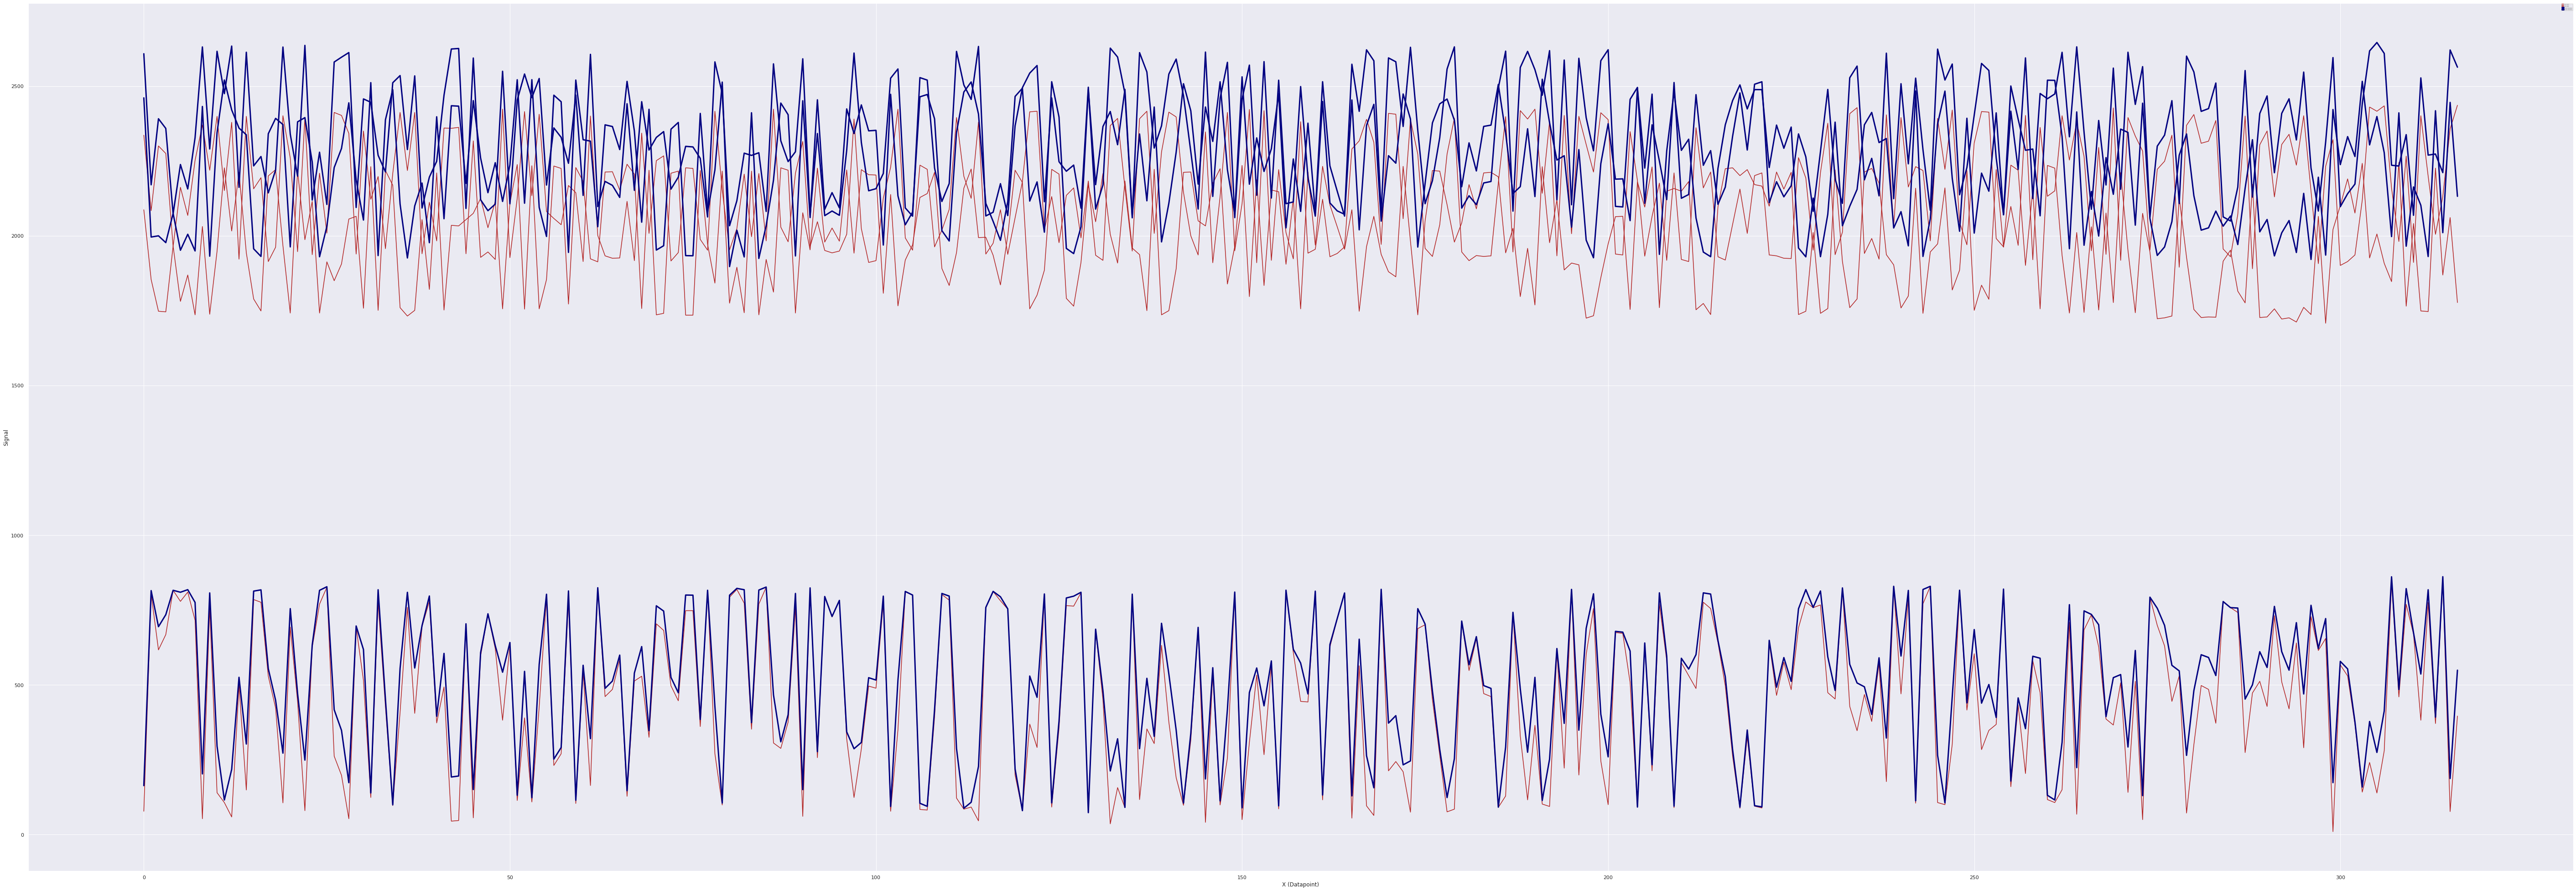

In [17]:
# Amplitude Extraction : applying the scipy Hilbert Transform and compute the absolute value:
new_data = data_master
new_signal = np.array(new_data.loc[0])
plt.figure(figsize=(100,35))
plt.plot(new_signal,color='firebrick',label='Raw Signal')
plt.xlabel('X (Datapoint)')
plt.ylabel('Signal')

plt.plot(np.abs(hilbert(new_signal)),color='navy',lw=3,label='Hilbert Transform')
plt.legend(fontsize=2)




new_data = data_master
new_signal = np.array(new_data.loc[1])
plt.figure(figsize=(100,35))
plt.plot(new_signal,color='firebrick',label='Raw Signal')
plt.xlabel('X (Datapoint)')
plt.ylabel('Signal')

plt.plot(np.abs(hilbert(new_signal)),color='navy',lw=3,label='Hilbert Transform')
plt.legend(fontsize=2)




new_data = data_master
new_signal = np.array(new_data.loc[2])
plt.figure(figsize=(100,35))
plt.plot(new_signal,color='firebrick',label='Raw Signal')
plt.xlabel('X (Datapoint)')
plt.ylabel('Signal')

plt.plot(np.abs(hilbert(new_signal)),color='navy',lw=3,label='Hilbert Transform')
plt.legend(fontsize=2)

In [19]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [20]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (2536000, 1, 3)
Test data shape: (634000, 1, 3)


In [21]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [22]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1280      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [23]:
# fit the model to the data
nb_epochs = 50
batch_size = 5000
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/50
24092/24092 [==============================] - 145s 6ms/step - loss: 0.0165 - val_loss: 0.0097
Epoch 2/50
24092/24092 [==============================] - 132s 5ms/step - loss: 0.0069 - val_loss: 0.0103
Epoch 3/50
24092/24092 [==============================] - 131s 5ms/step - loss: 0.0068 - val_loss: 0.0095
Epoch 4/50
24092/24092 [==============================] - 132s 5ms/step - loss: 0.0068 - val_loss: 0.0080
Epoch 5/50
24092/24092 [==============================] - 146s 6ms/step - loss: 0.0067 - val_loss: 0.0116
Epoch 6/50
24092/24092 [==============================] - 133s 6ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 7/50
24092/24092 [==============================] - 126s 5ms/step - loss: 0.0066 - val_loss: 0.0100
Epoch 8/50
24092/24092 [==============================] - 127s 5ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 9/50
24092/24092 [==============================] - 133s 6ms/step - loss: 0.0063 - val_loss: 0.0088
Epoch 10/50
24092/24092 [=====================

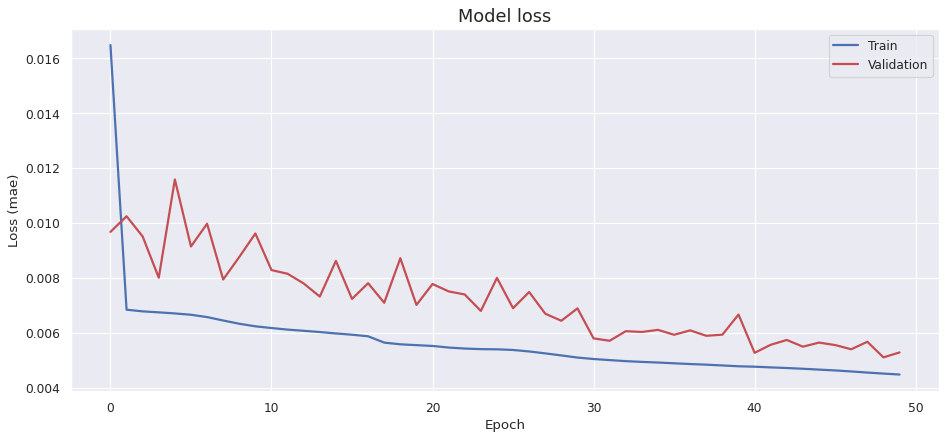

In [24]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. 

79250/79250 [==============================] - 246s 3ms/step


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

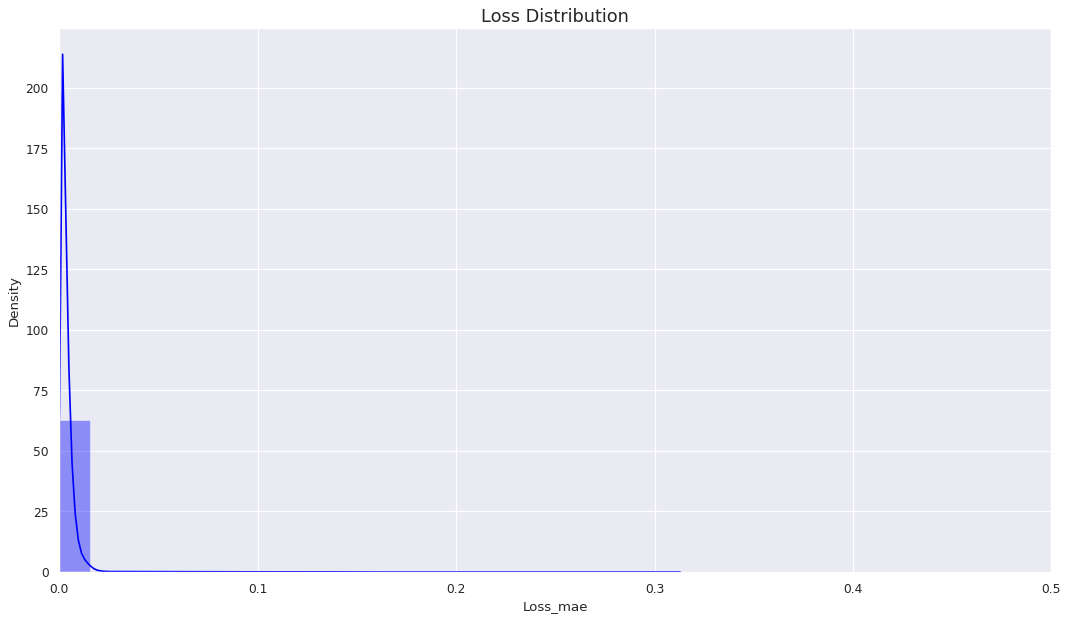

In [25]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.14 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

## **It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.**

In [37]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.21
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

19813/19813 [==============================] - 57s 3ms/step


Loss_mae  Threshold  Anomaly
6000  0.000758       0.21    False
6001  0.002096       0.21    False
6002  0.002910       0.21    False
6003  0.001743       0.21    False
6004  0.003496       0.21    False

In [38]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.21
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

79250/79250 [==============================] - 219s 3ms/step


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the anonmaly activity.

<AxesSubplot:>

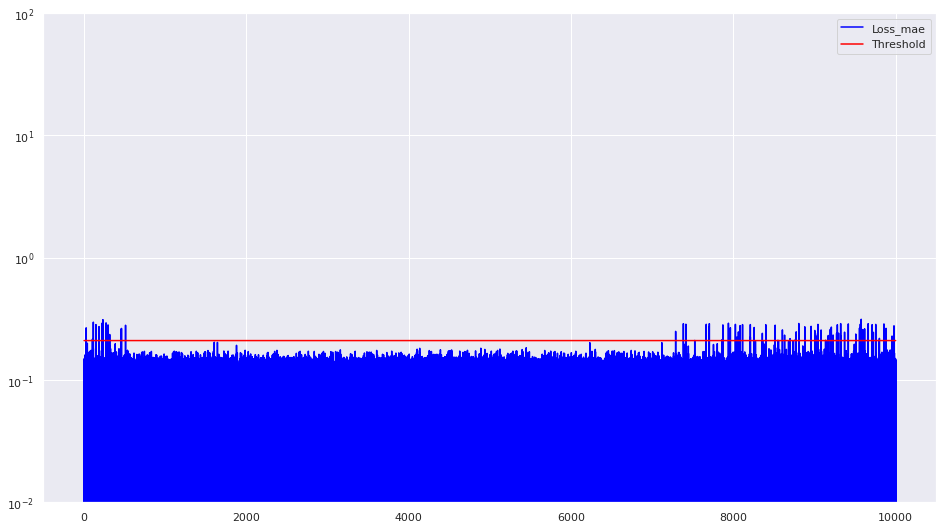

In [39]:
# plot anomaly threshold plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming malfunction/fault anomaly activity well in advance of the actual physical failure. 

In [40]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
